# dipy

This script is used to generate interpolations and associated plots using the Diffeomorphic Demons algorithm implemented in [*dipy*](http://nipy.org/dipy/).

It closely follows the example registration outlined in the official documentation:
http://nipy.org/dipy/examples_built/syn_registration_2d.html

In [2]:
import numpy as np
from dipy.data import get_data
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
import dipy.align.imwarp as imwarp
from dipy.viz import regtools
from utils import load_image, normalize_image
from stnwarp import plot_flow
import matplotlib.pyplot as plt
import json
from tqdm import tqdm_notebook as tqdm

In [3]:
def save_imfig(path, im):
    fig, ax = plt.subplots(1,1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im, cmap='gray')
    plt.savefig(path, bbox_inches='tight', dpi=300)

C:\Users\leifv\Anaconda3\envs\opticalflow-interpolation\lib\site-packages\skimage\transform\_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
C:\Users\leifv\Anaconda3\envs\opticalflow-interpolation\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\leifv\Anaconda3\envs\opticalflow-interpolation\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


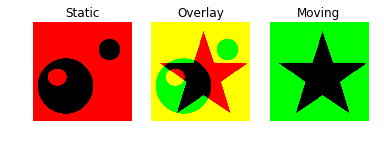

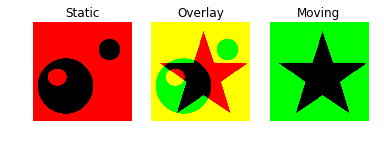

In [4]:
#paisley

moving = load_image('images/shapes/star.png', astype='grayscale')#fname_moving)
static = load_image('images/shapes/circles.png', astype='grayscale')#fname_static)

save_at = 'images/reconstruct/diff_starcircle_'

# fname_moving = get_data('reg_o')
# fname_static = get_data('reg_c')
# print(fname_moving, fname_static)

# moving = np.load(fname_moving)
# static = np.load(fname_static)

# plt.imsave('images/diff_circle.png',moving, cmap='gray')
# plt.imsave('images/diff_c.png',static, cmap='gray')

regtools.overlay_images(static, moving, 'Static', 'Overlay', 'Moving')#, 'input_images.png')

In [5]:
dim = static.ndim
metric = SSDMetric(dim)

params = dict(level_iters=[400, 200, 100, 50],
              inv_iter=100,
              opt_tol=1e-10,
              inv_tol=1e-10,
              step_length=0.25,
              ss_sigma_factor=0.2)

#with open(save_at+'params.json', 'w') as paramsfile:
#json.dump(params, paramsfile)

In [6]:
with tqdm(total=sum(params['level_iters'])) as pbar:
    last_level = None
    done_on_current_level = 0
    num_levels = len(params['level_iters'])
    
    def cb(*args):
        global last_level, done_on_current_level
        if hasattr(sdr,'current_level') and sdr.current_level != last_level:
            #print('checking at index',num_levels-last_level)
            dist = max(0,params['level_iters'][num_levels-last_level-1]-done_on_current_level)
            pbar.update(dist)
            last_level = sdr.current_level
            done_on_current_level = 0
            print('changing to',last_level)
        done_on_current_level +=1
        pbar.update(1)

    sdr = SymmetricDiffeomorphicRegistration(metric, **params, callback=cb)
    last_level = num_levels-1
    print('last_level starts with',last_level)
    
    mapping = sdr.optimize(static, moving)

last_level starts with 3
Creating scale space from the moving image. Levels: 4. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 4. Sigma factor: 0.200000.
Optimizing level 3
Optimizing level 2
changing to 2
Optimizing level 1
changing to 1
Optimizing level 0
changing to 0



(200, 200, 2)


[]

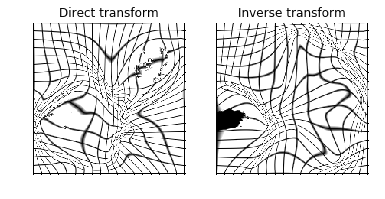

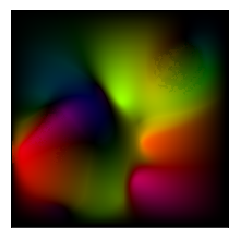

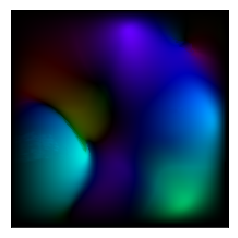

In [7]:
regtools.plot_2d_diffeomorphic_map(mapping, 10)#, 'diffeomorphic_map.png')
print(mapping.get_forward_field().shape)

fig, axs = plt.subplots(1,1)
plot_flow(axs, np.rollaxis(mapping.get_forward_field(), 2))
axs.set_xticks([])
axs.set_yticks([])
#np.save(save_at+'diff_forw.npy', mapping.get_forward_field())
#plt.savefig(save_at+'diff_forw.png', bbox_inches='tight', dpi=300)

fig, axs = plt.subplots(1,1)
plot_flow(axs, np.rollaxis(mapping.get_backward_field(), 2))
axs.set_xticks([])
axs.set_yticks([])
#np.save(save_at+'diff_backw.npy', mapping.get_backward_field())
#plt.savefig(save_at+'diff_backw.png', bbox_inches='tight', dpi=300)

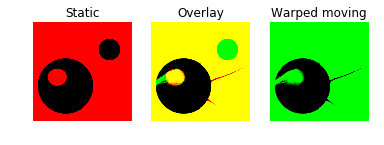

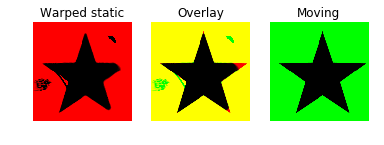

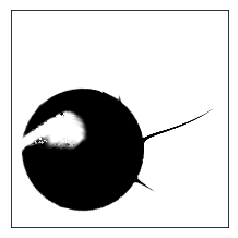

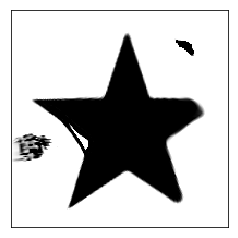

In [9]:
warped_moving = mapping.transform(moving, 'linear')
regtools.overlay_images(static, warped_moving, 'Static','Overlay','Warped moving')
   #'direct_warp_result.png')
warped_static = mapping.transform_inverse(static, 'linear')
regtools.overlay_images(warped_static, moving,'Warped static','Overlay','Moving')
   #'inverse_warp_result.png')
    
fig, axs = plt.subplots(1,1)
axs.set_xticks([])
axs.set_yticks([])
plt.imshow(warped_moving, cmap='gray')
#plt.savefig(save_at+'diff_warpm.png', bbox_inches='tight', dpi=300)

overlay = np.zeros((*static.shape, 3))
overlay[:,:,0] = normalize_image(warped_moving)
overlay[:,:,1] = normalize_image(static)
#save_imfig(save_at+'diff_warpm_overlay.png', overlay)

fig, axs = plt.subplots(1,1)
axs.set_xticks([])
axs.set_yticks([])
plt.imshow(warped_static, cmap='gray')
#plt.savefig(save_at+'diff_warps.png', bbox_inches='tight', dpi=300)

overlay = np.zeros((*static.shape, 3))
overlay[:,:,0] = normalize_image(warped_static)
overlay[:,:,1] = normalize_image(moving)
#save_imfig(save_at+'diff_warps_overlay.png', overlay)